In [1]:
import numpy as np
import time
import requests
from copy import deepcopy as dc
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
import functools
import itertools
import string
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon,Point,mapping
import numba as nb

# Back to a very old one I've been ignoring for a while. Need to limit the swings to inside the area and it should work

In [2]:
coords1 =  [(0, 4), (0, 11), (0, 13), (1, 2), (1, 6), (1, 8), (1, 18), (2, 14), (3, 4), (3, 6),
           (3, 12), (3, 15), (4, 3), (4, 7), (4, 10), (4, 18), (5, 2), (5, 11), (5, 19), (7, 1),
           (7, 9), (7, 13), (8, 3), (8, 10), (8, 16), (9, 0), (9, 12), (9, 18), (10, 1), (10, 8),
           (11, 3), (11, 5), (11, 10), (12, 8), (13, 0), (13, 19), (15, 1), (15, 11), (15, 19),
           (16, 0), (16, 2), (16, 7), (16, 13), (17, 9), (18, 6), (18, 10), (18, 18), (19, 2), (19, 4),
           (19, 14)]

coords2= [(0, 0), (0, 2), (0, 4), (0, 10), (0, 14), (0, 16), (1, 17), (1, 18), (2, 7), (2, 13), (2, 15),
           (2, 18), (3, 0), (3, 8), (3, 14), (3, 19), (4, 3), (4, 4), (4, 11), (4, 17), (5, 15), (5, 19),
           (6, 12), (7, 7), (7, 15), (7, 18), (8, 19), (9, 0), (9, 3), (11, 15), (12, 4), (12, 7), (13, 11),
           (13, 17), (14, 15), (15, 13), (15, 19), (16, 11), (16, 16), (17, 9), (18, 7), (18, 14),(19, 5), (19, 19)]

coords = [(7, 0), (9, 7), (11, 0), (13, 3), (15, 0), (17, 3), (11, 3)]

[i for i,j in enumerate(coords1) if j ==(18,18)]

[46]

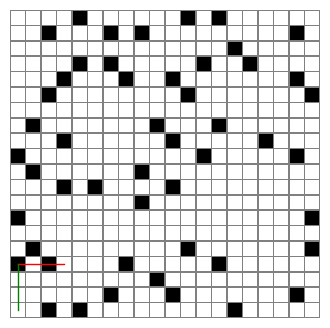

In [3]:
def print_coord(coords,start=[],swings=[]):
    grid = np.zeros((20,20))
    for (x,y) in coords:    
        grid[x,y] = 1
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    y = grid.astype("int").astype('str')
    y[y=="0"] =""
    sns.heatmap(grid,cmap='Greys',cbar=False,linecolor="grey",
            linewidths=0.5,fmt="",annot_kws={"size":10,"weight": "bold"})
    for (a,b),(c,d) in swings:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="r")
    for (a,b),(c,d) in start:
        ax.plot([b+0.5,d+0.5],[a+0.5,c+0.5], linewidth=1,color="g")
    ax.axis('off')  
    plt.show()

print_coord(coords1,start=[((19,0),(16,0))],swings=[((16,0),(16,3))])


In [4]:
def to_polar(start,pivot):
    s = np.array(start)
    p = np.array(pivot)
    l = p-s
    r = np.linalg.norm(l)
    cosTh = np.dot(l,[-1,0])
    sinTh = np.cross(l,[-1,0])
    a = np.rad2deg(np.arctan2(sinTh,cosTh)+np.pi) % 360
    return r,a

lines = {((x,y),(i,j)):to_polar((x,y),(i,j)) for x,y,i,j in itertools.product(range(20),repeat=4) }

In [5]:
def edge_hit(c):
    N =20
    not_c = [(i,j) for i,j in itertools.product(range(20),repeat=2) if (i,j) not in c]
    angles = defaultdict(list)
    for a,b in c:
        for i,j in not_c:
            dist,angle = lines[((a,b),(i,j))]
            if b+.5 < dist:
                la = np.rad2deg(np.arccos((b+0.5)/dist))
                angles[((a,b),(i,j))] += [270+la,270-la]
            if N-(b+0.5) < dist:
                ra = np.rad2deg(np.arccos((N-(b+0.5))/dist))
                angles[((a,b),(i,j))] += [90+ra,90-ra]
            if a+.5 < dist:
                ta = np.rad2deg(np.arccos((a+0.5)/dist))
                angles[((a,b),(i,j))] += [ta,360-ta]
            if N-(a+0.5) < dist:
                ba = np.rad2deg(np.arccos((N-(a+0.5))/dist))
                angles[((a,b),(i,j))] += [180+ba,180-ba]             
    return angles

edge_angles = edge_hit(coords1)


In [6]:
@nb.njit()
def between_angle(start_angle,end_angle,block_angles):
    blocks = np.concatenate((block_angles-360,block_angles+0,block_angles+360))
    min_angle = np.max(blocks[blocks <= start_angle])
    max_angle = np.min(blocks[blocks >= start_angle])
    if start_angle < np.min(block_angles) and end_angle > np.max(block_angles):
        end_angle-360
    if start_angle > np.max(block_angles) and end_angle < np.min(block_angles):
        end_angle+360    
    if end_angle >= min_angle and end_angle <= max_angle:
        return True
    else:
        return False

In [7]:
def poss_swing(x,y,coords,lines,edges):
    if (x,y) ==(2,17):
        return [((1, 18), (0, 19), 1.4142135623730951)]    
    if (x,y) ==(19,0) and (16,0) in coords:
        return [((16, 0), (16, 3), 3.0)]   
    
    poss = []
    scores = []
    for (a,b) in coords:
        #print(a,b)
        distance,start_angle = lines[((x,y),(a,b))]
        if distance < 5:
            continue
        blocks = np.array([angle for dist,angle in 
                         [lines[((i,j),(a,b))] for (i,j) in coords if (i,j) !=(a,b)] 
                          if dist < distance ] 
                          + edges[((a,b),(x,y))] 
                          +[-360,+720])
        #print([((i,j),lines[((i,j),(a,b))][1]) for (i,j) in coords if lines[((i,j),(a,b))][0] < distance and (i,j) !=(a,b)])
        #print(start_angle,sorted(block_angles))
        #print(min_angle,max_angle)
        poss += [((a,b),(i,j),distance) for i,j in itertools.product(range(20),repeat=2) if (i,j) not in coords 
                     and (i,j) != (x,y) 
                     and (i,j) != (a,b) 
                 if lines[((i,j),(a,b))][0] == distance
                 and between_angle(start_angle,lines[((i,j),(a,b))][1],blocks)
                 ]
    return poss 
swings = poss_swing(19,0,coords1,lines,edge_angles)
swings

[((16, 0), (16, 3), 3.0)]

In [8]:
def solver(target,coords,lines,edges,initial=(19,0)):
    soln = []
    paths=[[initial,coords,0,[],[]]] #current point, coords left,score,path,pivots
    best_score = .75
    
    while len(soln) == 0:
        (x,y),c,s,p,pv = paths.pop(0)
        if s < best_score:
            if (x,y) == target:
                #print([s,p,pv])
                soln = [s,p,pv]
                best_score = np.copy(s)
            else:
                swings = poss_swing(x,y,c,lines,edges)
                for (a,b),(i,j),distance in swings:
                    new_c=dc(c)
                    new_c.remove((a,b))
                    new_path = p+[(i,j)]
                    new_pivot = pv+[(a,b)]
                    new_s = s + 1/distance**2
                    paths.append([(i,j),new_c,new_s,new_path,new_pivot])
    return(soln)

Best Score is 0.7227 in 1029.6318 secs


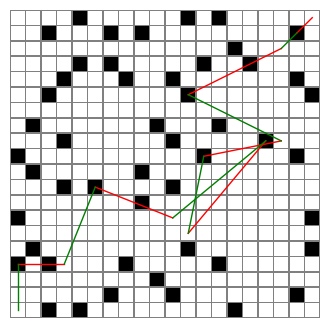

In [9]:
start = time.time()
initial= (19,0)
score,path,pivots = solver((0,19),coords1,lines,edge_angles,initial)

print("Best Score is {:.4f} in {:.4f} secs".format(score,time.time()-start))
swings = ([[x,pivots[i]] for i,x in enumerate(path)])
starts = [initial]+[i[0] for i in swings[:-1]] 
pivots = [i[1] for i in swings]

start = [i for i in zip(starts,pivots)]
print_coord(coords1,start=start,swings=swings)

In [10]:
url='https://www.janestreet.com/puzzles/swing-time-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:14]))))

### August 2016 : Solution

Very open-ended puzzle this month! The best solution we found to this month’s puzzle, along with 10 of you, had a cost of about 0.7082. There are actually a couple of ways to achieve that cost, but one is:
(a4,c3)
(k2,d6)
(t7,d8)
(e1,j6)
(t7,j8)
(q12,r4)
(i8,r12)
(l15,r18)
(s19,t20)
Here’s a video illustrating what that solution looks like:
Congratulations to everyone who found a valid path!

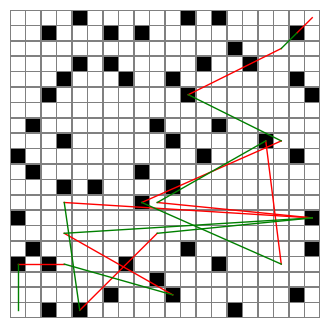

In [11]:
soln = [('a4','d4'),('k2','d6'),('t7','d8'),('e1','j6'),('t7','j8'),('q12','r4'),('i8','r12'),('l15','r18'),('s19','t20')]
letters =[i for i in string.ascii_lowercase[:20]]

swings = [((20-int(i[1:]),letters.index(i[0])),(20-int(j[1:]),letters.index(j[0]))) for (j,i) in soln]
starts = [(19,0)]+[i[0] for i in swings[:-1]] 
pivots = [i[1] for i in swings]

start = [i for i in zip(starts,pivots)]

print_coord(coords1,start=start,swings=swings)

In [12]:
print(starts)

[(19, 0), (16, 3), (14, 3), (12, 3), (14, 9), (12, 9), (16, 17), (8, 17), (2, 17)]
